In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import nbimporter

import h_material_thermal_characteristics as mtc

Importing Jupyter notebook from h_material_thermal_characteristics.ipynb


# 一般部位の層構成を作成するモジュール

## I. 関数

### 1. 直接U値入力からの層構成の作成

#### 1) 断熱材の厚さの推定

$$ l_{res} = \left( \frac{ 1 }{ U } - R_o - \sum_i{R_{other,i}} - R_i \right) \lambda_{res} $$

ただし、$l_{res}$が0を下回る場合は0とする。

$l_res$:断熱材の厚さ, m  
$U$:熱貫流率, W/m<sup>2</sup>K  
$R_o$:熱的境界外側（外気側）又は界壁・界床における隣接住戸の室内側の表面熱伝達抵抗, m<sup>2</sup>K/W  
$R_{other,i}$:断熱材以外の部材$i$の熱抵抗, m<sup>2</sup>K/W  
$R_i$:熱的境界内側（室内側）又は界壁・界床における対象住戸の室内側の表面熱伝達抵抗, m<sup>2</sup>K/W  
$\lambda_{res}$:断熱材の熱伝導率, W/mK

In [2]:
def get_thermal_insulation_thickness(u, r_o, r_i, r_others, lambda_res):
    return max( 0.0, ( 1 / u - r_o - sum(r_others) - r_i ) * lambda_res )

#### 2) 表面熱伝達抵抗

表面熱伝達抵抗は部位の種類と隣接空間の種類によって決定される。

In [3]:
def get_thermal_resistance(general_part_type, next_space):
    
    r_i, r_o = mtc.get_surface_thermal_resistance(general_part_type=general_part_type, next_space=next_space)
    
    return r_i, r_o

#### 3) 断熱材以外に想定する物質とその物性値

| 番号 | 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| 1 | せっこうボード | 0.0095 | 0.22 | 830.0 |
| 2 | 合板 | 0.012 | 0.16 | 720.0 |
| 3 | コンクリート | 0.120 | 1.6 | 2000.0 |

In [4]:
def get_material(name):
    
    return {
        'gypsum_board' : {
            'name'          : 'gypsum_board',
            'conductivity'  : 0.22,
            'specific_heat' : 830.0,
            'thickness'     : 0.0095,
        },
        'concrete' : {
            'name'          : 'concrete',
            'conductivity'  : 1.6,
            'specific_heat' : 2000.0,
            'thickness'     : 0.120,
        },
        'plywood' : {
            'name' :'plywood',
            'conductivity' : 0.16,
            'specific_heat' : 720.0,
            'thickness' : 0.012,
        }
    }[name]

$$ R_{other,i} = \frac{ l_{other,i} }{ \lambda_{other,i} } $$

$l_{other,i}$:部材$i$の厚さ, m  
$\lambda_{other,i}$:部材$i$の熱伝導率, W/mK  
ただし、ここで部材$i$は、断熱材を除く。

In [5]:
def get_resistance(names):

    def calc_resistance(name):
        
        m = get_material(name)
        
        return m['thickness'] / m['conductivity']
    
    return [calc_resistance(name) for name in names if name != 'insulation']

#### 4) 層構成

番号が小さい方が室内側／対象住戸側である。  
番号が大きい方が室外側／隣接住戸側である。

断熱材は住宅用グラスウール断熱材16K相当を想定し、熱伝導率を0.045 W / m K、容積比熱を13.0 J / L と想定する。

構造が木造・鉄骨造・その他／不明の場合

| 部位の種類 | 番号:材料 |
|:---|---|
| 屋根・天井・外壁 | 1:せっこうボード 2:断熱材 |
| 床 | 1:合板 2:合板 3:断熱材 |
| 界壁 | 1:せっこうボード 2:断熱材 3:せっこうボード |
| 上階側界床 | 1:せっこうボード 2:断熱材 3:合板 4:合板 |
| 下界側階床 | 1:合板 2:合板 3:断熱材 4:せっこうボード |

構造が鉄筋コンクリート造等の場合

| 部位の種類 | 番号:材料 |
|:---|---|
| 屋根・天井・外壁 | 1:せっこうボード 2:断熱材 3:コンクリート |
| 床 | 1:合板 2:合板 3:断熱材 4:コンクリート |
| 界壁 | 1:せっこうボード 2:断熱材 3:コンクリート 4:断熱材 5:せっこうボード |
| 上階側界床 | 1:せっこうボード 2:コンクリート 3:断熱材 4:合板 5:合板 |
| 下界側階床 | 1:合板 2:合板 3:断熱材 4:コンクリート 5:せっこうボード |

In [6]:
def get_layer_names(general_part_type, structure):
    
    if structure == 'wood' or structure == 'steel' or structure == 'other':
        
        return {
            'roof'                    : ['gypsum_board', 'insulation'],
            'ceiling'                 : ['gypsum_board', 'insulation'],
            'wall'                    : ['gypsum_board', 'insulation'],
            'floor'                   : ['plywood', 'plywood', 'insulation'],
            'boundary_wall'           : ['gypsum_board', 'insulation', 'gypsum_board'],
            'upward_boundary_floor'   : ['gypsum_board', 'insulation', 'plywood', 'plywood'],
            'downward_boundary_floor' : ['plywood', 'plywood', 'insulation', 'gypsum_board'],
        }[general_part_type]      
    
    elif structure == 'rc':
        
        return {
            'roof'                    : ['gypsum_board', 'insulation', 'concrete'],
            'ceiling'                 : ['gypsum_board', 'insulation', 'concrete'],
            'wall'                    : ['gypsum_board', 'insulation', 'concrete'],
            'floor'                   : ['plywood', 'plywood', 'insulation', 'concrete'],
            'boundary_wall'           : ['gypsum_board', 'insulation', 'concrete', 'insulation', 'gypsum_board'],
            'upward_boundary_floor'   : ['gypsum_board', 'concrete', 'insulation', 'plywood', 'plywood'],
            'downward_boundary_floor' : ['plywood', 'plywood', 'insulation', 'concrete', 'gypsum_board'],
        }[general_part_type]      
        
    else:
        
        raise ValueError

## II. 統合

In [7]:
def get_layers(general_part_type, next_space, structure, u_value):
    
    r_i, r_o = get_thermal_resistance(general_part_type, next_space)
    
    names = get_layer_names(general_part_type, structure)
    
    r_others = get_resistance(names)
    
    t = get_thermal_insulation_thickness(u=u_value, r_o=r_o, r_i=r_i, r_others=r_others, lambda_res=0.045)
    
    def get_layer(name):
        if name == 'gypsum_board' or name == 'concrete' or name == 'plywood':
            return get_material(name)
        elif name == 'insulation':
            return {
                'name'          : 'insulation',
                'conductivity'  : 0.045,
                'specific_heat' : 13.0,
                'thickness'     : t,
            }
    return [get_layer(name) for name in names]

## III. 使用例

In [8]:
get_layers(general_part_type='wall',
           next_space='outdoor',
           structure='wood',
           u_value=0.538 )

[{'name': 'gypsum_board',
  'conductivity': 0.22,
  'specific_heat': 830.0,
  'thickness': 0.0095},
 {'name': 'insulation',
  'conductivity': 0.045,
  'specific_heat': 13.0,
  'thickness': 0.0749499408583981}]

U値と断熱材厚の関係のグラフ作成

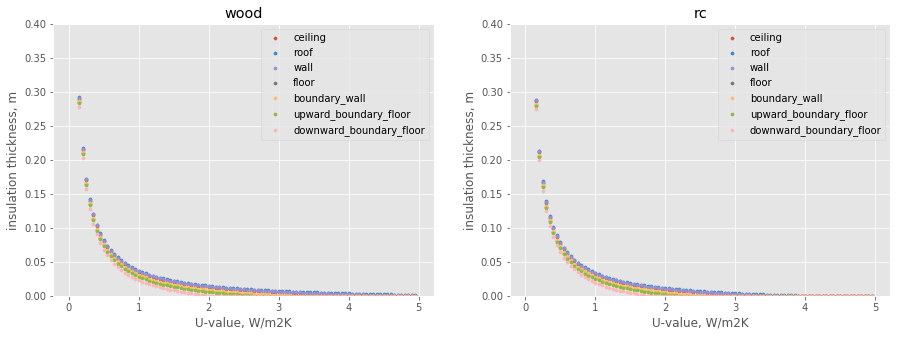

In [9]:
xs = np.arange(0.05, 5.0, 0.05)

cases = [
    ('ceiling',                 'open_space'),
    ('roof',                    'outdoor'),
    ('wall',                    'outdoor'),
    ('floor',                   'outdoor'),
    ('boundary_wall',           'air_conditioned'),
    ('upward_boundary_floor',   'air_conditioned'),
    ('downward_boundary_floor', 'air_conditioned'),
]

fig = plt.figure(figsize = (15, 5))
plt.style.use('ggplot')

for i, structure in enumerate(['wood','rc']):
    
    sp = fig.add_subplot(1, 2, i+1)

    sp.set_title(structure)
    sp.set_xlabel('U-value, W/m2K')
    sp.set_ylabel('insulation thickness, m')
    sp.set_ylim(0.0, 0.4)
    
    for c2 in cases:

        r_i, r_o = get_thermal_resistance(c2[0], c2[1])   
        names = get_layer_names(c2[0], structure)
        r_others = get_resistance(names)
        ys = [get_thermal_insulation_thickness(u=x, r_o=r_o, r_i=r_i, r_others=r_others, lambda_res=0.045) for x in xs]
        sp.scatter(xs, ys, 10, label=c2[0])
        
    sp.legend()

plt.show()